# <b><font color='blue'>Notebook para la registración de la distribución de dosis 2D medida (film) con la distribución de dosis de referencia (planificada)</font></b>

<font color='blue'>Este script hace solamente la registración de la imagen de planificación con la imagen del film. El output es la imagen de planificación registrada y resampleada con la del film. Para lograr esto, se registra la imagen del film sobre la planificación (manual y/o automáticamente) y se hace el resampling de la planificación sobre el film.</font>

<b><font color='blue'>Importación de bibliotecas</font></b>

In [1]:
import scipy
import wx

import dicom
from dicom.dataset import Dataset, FileDataset
#import dicom.uid

import SimpleITK as sitk

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from ipywidgets import *
%run registration_utilities.py
from IPython.display import display
plt.style.use('ggplot')

<b><font color='blue'>Funciones auxiliares</font></b>

In [2]:
def get_path(wildcard):
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Open', wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

def get_array_extent(array_size, pixel_spacing, origin):
    # return extent : scalars (left, right, bottom, top)
    
    x_min = origin[0] - pixel_spacing[0]/2.0
    x_max = array_size[1]*pixel_spacing[0] - pixel_spacing[0]/2.0 + origin[0]
    y_min = origin[1] - pixel_spacing[1]/2.0
    y_max = array_size[0]*pixel_spacing[1] - pixel_spacing[1]/2.0 + origin[1]
                                                                                                         
    return np.array([x_min, x_max, y_max, y_min])

<b><font color='blue'>Funciones de visualización</font></b>

In [3]:
def display_array(my_array, array_extent, l_limit, u_limit):     
    
    plt.figure(figsize = (8, 8))

    plt.imshow(my_array, cmap = 'Greens', vmin=l_limit, vmax = u_limit, 
               interpolation = 'none', extent = array_extent)#

    plt.show()
    
def display_arrays_with_alpha_and_shift(plan_array, film_array, 
                              plan_extent, film_extent, 
                              alpha,
                              plan_l_limit, plan_u_limit,
                              film_l_limit, film_u_limit, 
                              film_shift_x = 0.0, film_shift_y = 0.0):
    
    global manual_shift      
        
    manual_shift = np.array([film_shift_x, film_shift_y])
    
    film_extent = [film_extent[0]+manual_shift[0], film_extent[1]+manual_shift[0], 
                   film_extent[2]+manual_shift[1], film_extent[3]+manual_shift[1]]

    plt.figure(figsize = (6, 6))

    plt.imshow(film_array,  alpha = 1.0,cmap = 'Greens', vmin = film_l_limit, vmax = film_u_limit, 
               interpolation = 'none', extent = film_extent)

    plt.imshow(plan_array,alpha = alpha, cmap = 'gray', vmin = plan_l_limit, vmax = plan_u_limit, 
               interpolation = 'none', extent = plan_extent)
   
    plt.show()

    

def display_arrays_with_alpha(plan_array, film_array, 
                              plan_extent, film_extent, 
                              alpha, 
                              plan_l_limit, plan_u_limit,
                              film_l_limit, film_u_limit):
    global film_shift      
        
    plt.figure(figsize = (6, 6))

    plt.imshow(film_array,  alpha = 1.0,cmap = 'Greens', vmin = film_l_limit, vmax = film_u_limit, 
               interpolation = 'none', extent = film_extent)

    plt.imshow(plan_array,alpha = alpha, cmap = 'gray', vmin = plan_l_limit, vmax = plan_u_limit, 
               interpolation = 'none', extent = plan_extent)
   
    plt.show()    


## <b><font color='blue'>Procesamiento de la imagen del film</font></b>
<font color='blue'>Utiliza la funcion get_path (que a su vez utiliza de wxpython) para obtener el path del archivo tiff correspondiente al film. Como wx devuelve el path en unicode, se codifica con 'utf-8' para que sitk pueda leer la imagen. Para leer la imagen debe usarse el tipo de variable -1 (unknown) o sitk.sitkVectorInt16 (ya que los films vienen en este tipo de variable).</font>  


<font color='blue'>Para calibrar la imagen (dosimétrica y geométricamente), es conveniente trabajar con arrays de numpy. Para hacer eso, se extrae de la imagen el array con sitk.GetArrayFromImage(). Se extrae directamente el canal rojo (tener en cuenta que el rojo es el de íncide cero porque en numpy se ordenan en RGB).</font>  

In [4]:
#----> Lectura del archivo <-----#
filename_film = get_path('*.tif')
filename_film = filename_film.encode('utf-8')

film_image_color = sitk.ReadImage(filename_film, -1)


#----> Numpy <-----#
# Extracción del canal rojo y de la metadata
film_array = sitk.GetArrayFromImage(film_image_color)[:,:,0]

print film_array.dtype
film_size = film_array.shape

film_pixel_spacing = np.float64(film_image_color.GetSpacing())

# Coordenadas x, y del pixel superior izquierdo, de tal manera que el (0,0) quede en el centro de la imagen
film_origin_original = np.array([(1 - film_size[1])*film_pixel_spacing[0]/2.0, (1 - film_size[0])*film_pixel_spacing[1]/2.0])

film_extent_original = get_array_extent(film_size, film_pixel_spacing, film_origin_original)

[min_val_film, max_val_film] = np.float64([film_array.min(), film_array.max()])


print filename_film

uint16
C:\Users\Roy\Desktop\Exp4\Datos\Mendoza (datos nuestros)\Calib 9-4-16\Film_75_001.tif


<b><font color='blue'>Flip a la imagen del film </font></b><font color='blue'>(opcional)</font>

In [5]:
film_array = np.flipud(film_array)

<b><font color='blue'>Rotación de la imagen del film </font></b><font color='blue'>(opcional)</font>

In [6]:
# cada vez que esta celda es ejecutada, la imagen rota 90 grados clockwise

film_array = np.rot90(film_array, k=-1)
    
film_size = film_array.shape

# Coordenadas x, y del pixel superior izquierdo, de tal manera que el (0,0) quede en el centro de la imagen
film_origin_original = np.array([(1 - film_size[1])*film_pixel_spacing[0]/2.0, (1 - film_size[0])*film_pixel_spacing[1]/2.0])

film_extent_original = get_array_extent(film_size, film_pixel_spacing, film_origin_original)

<b><font color='blue'><b><b>Gráfico de la imagen del film</font></b> <font color='blue'>(opcional)</font>

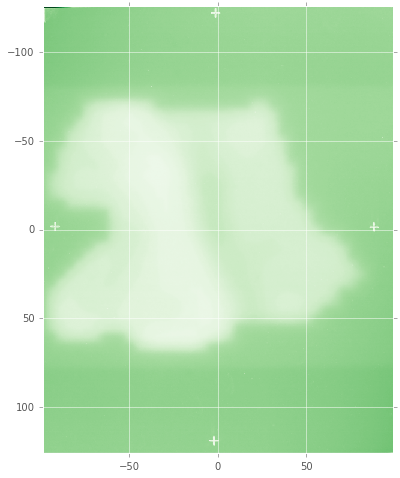

In [7]:
%matplotlib inline

interact(display_array, my_array = fixed(film_array), 
         array_extent = fixed(film_extent_original),
         l_limit =(min_val_film,max_val_film,1.0), u_limit =(min_val_film,max_val_film,1.0));

## <b><font color='blue'>Procesamiento de la imagen planificada</font></b> 

In [8]:
# Load dicom 2D distribution (reference image)
# Pydicom automáticamente crea arrays de numpy

#----> Lectura del archivo <-----#
filename_dcm = get_path('*.dcm')

plan = dicom.read_file(filename_dcm)

#----> Numpy <-----#
plan_array = plan.pixel_array.astype(np.float32) # se hace un cast a float32 porque es necesario para la registracion automática

plan_size = plan_array.shape

plan_pixel_spacing = np.array(plan.PixelSpacing)

plan_origin = [(1 - plan_size[1])*plan_pixel_spacing[0]/2.0, (1 - plan_size[0])*plan_pixel_spacing[1]/2.0]

plan_extent = get_array_extent(plan_size, plan_pixel_spacing, plan_origin)

[min_val_plan, max_val_plan] = np.float64([plan_array.min(), plan_array.max()])

#----> ITK <-----#
# Creo la correspondiente imagen de itk de la imagen planificada. Se le agrega la metadad de tamaño de pixel y de origen.
# Esta imagen no será modificada hasta el resampling que se hace luego de la registración.

plan_image = sitk.GetImageFromArray(plan_array)

plan_image.SetSpacing(plan_pixel_spacing)

plan_image.SetOrigin(plan_origin)

<b><font color='blue'><b>Gráfico de la imagen planificada</font></b> <font color='blue'>(opcional)</font>

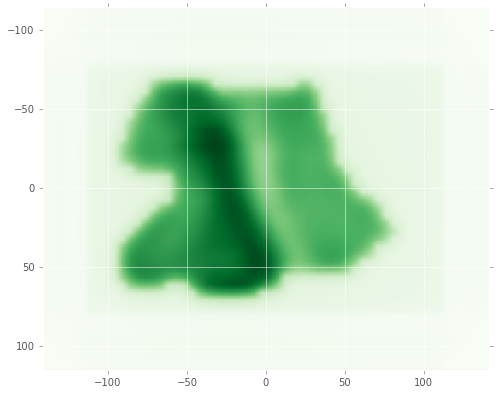

In [9]:
%matplotlib inline

interact(display_array, my_array = fixed(plan_array),
         array_extent = fixed(plan_extent),
         l_limit =(min_val_plan,max_val_plan,1.0), u_limit =(min_val_plan,max_val_plan,1.0));

# <font color='blue'><b>Registración</font></b>
## <font color='blue'>Aproximación manual inicial</font>

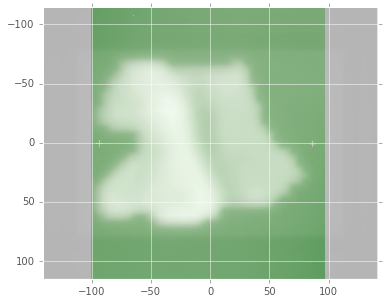

In [10]:
# Shift manual y su correspondiente shift automático
# Siriraj: shift_x = -7.0, shift_y = -18.0 ----> (1.8279955630041036, -2.163946447995959)
# Chulabhorn: shift_x = -10.0, shift_y = -10.0 ---->(-1.0049272267347835, -0.8496916449763339)
# Ramathibodi: shift_x = 0.0, shift_y = 0.0 ---->(2.536617012218259, 0.5497287710462802)
# Srinacharin: shift_x = 0.0, shift_y = 0.0 ---->(5.466764119037726, -2.4691845941267467)


%matplotlib inline

    
interact(display_arrays_with_alpha_and_shift, plan_array = fixed(plan_array), film_array =fixed(film_array), 
                              plan_extent = fixed(plan_extent), film_extent = fixed(film_extent_original), 
                              alpha = (0.0,1.0,0.01), 
                              plan_l_limit = (min_val_plan,max_val_plan,1.0), plan_u_limit = (min_val_plan,max_val_plan,1.0),
                              film_l_limit = (min_val_film,max_val_film,1.0), film_u_limit = (min_val_film,max_val_film,1.0), 
                              film_shift_x =(-200.0,200.0,0.5),film_shift_y =(-200.0,200.0,0.5));



## <b><font color='blue'>Registración fina automática</font></b> 

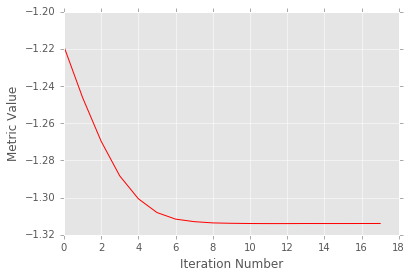

(-2.4873033667480025, -0.1888092101507544)


In [13]:
#----> ITK <-----#
# Recomposición del film como imagen de ITK para luego hacer la registración fina automática
film_image = sitk.GetImageFromArray(film_array.astype(np.float32))

film_image.SetSpacing(film_pixel_spacing)

# Le paso la metadata del origen calculado a la imagen del film 
film_origin_manual_shift = film_origin_original + manual_shift # manual shift es una variable global que sale de la traslacion
film_extent_after_transf = get_array_extent(film_size, film_pixel_spacing, film_origin_manual_shift)
film_image.SetOrigin(film_origin_manual_shift)


# Inicializar transformacion
dimension = 2

transform =  sitk.TranslationTransform(dimension)


print('Parameters: ' + str(transform.GetParameters()))
print('Offset:     ' + str(transform.GetOffset()))
print('FixedParameters: ' + str(transform.GetFixedParameters()))

# Inicializar método de registracion
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(0.8)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=160)
registration_method.SetOptimizerScalesFromPhysicalShift() 

registration_method.SetInitialTransform(transform, inPlace=False)

registration_method.AddCommand(sitk.sitkStartEvent, metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, metric_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: metric_plot_values(registration_method))

final_transform_v1 = registration_method.Execute(plan_image, film_image) #fixed_image, moving_image

#print(transform)
print(final_transform_v1.GetParameters())

## <b><font color='blue'>Resampling</font></b> 
<font color='blue'>El caso 0 corresponde a cuando se ha hecho registracion manual sin registracion automática. El caso 1 corresponde a cuando se ha hecho registracion manual más automática.</font>

In [223]:
caso = 1

if caso == 0:
    
    film_origin_manual_shift = film_origin_original + manual_shift
    
    film_extent_after_transf = get_array_extent(film_size, film_pixel_spacing, film_origin_manual_shift)
    
    film_image.SetOrigin(film_origin_manual_shift)
    
    
    interpolator = sitk.sitkLinear
    identity = sitk.Transform(2, sitk.sitkIdentity)
    default_value = np.nan
    reference_image = film_image
    image = plan_image
    plan_image_resampled = sitk.Resample(image, reference_image, identity,
                          interpolator, default_value)
  
elif caso == 1:
    
    interpolator = sitk.sitkLinear

    default_value = np.nan
    reference_image = film_image
    image = plan_image
    plan_image_resampled = sitk.Resample(image, reference_image, final_transform_v1.GetInverse(),interpolator, default_value)



plan_array_resampled = sitk.GetArrayFromImage(plan_image_resampled)

plan_size_resampled = plan_array_resampled.shape

plan_pixel_spacing_resampled = plan_image_resampled.GetSpacing()[0:2]

plan_origin_resampled = plan_image_resampled.GetOrigin()

plan_extent_resampled = get_array_extent(plan_size_resampled, plan_pixel_spacing_resampled, plan_origin_resampled)

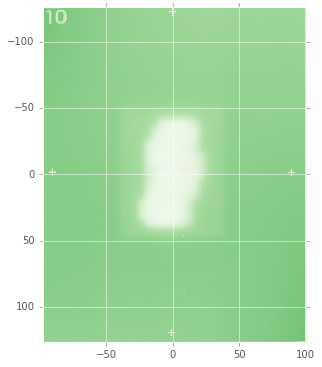

In [224]:
%matplotlib inline


interact(display_arrays_with_alpha, plan_array = fixed(plan_array_resampled), film_array=fixed(film_array), 
                        plan_extent = fixed(plan_extent_resampled), film_extent = fixed(film_extent_after_transf), 
                        alpha = (0.0,1.0,0.01), 
                        plan_l_limit = (min_val_plan,max_val_plan,1.0),plan_u_limit = (min_val_plan,max_val_plan,1.0),
                        film_l_limit = (min_val_film,max_val_film,1.0),film_u_limit = (min_val_film,max_val_film,1.0));        

In [225]:
print plan_origin_resampled
print film_origin_manual_shift
print plan_extent_resampled
print film_extent_after_transf

(-97.72133333333333, -125.81466666666667)
[ -97.72133333 -125.81466667]
[ -97.89066667   99.89066667  125.984      -125.984     ]
[ -97.89066667   99.89066667  125.984      -125.984     ]


## <b><font color='blue'>Guardado</font></b> 

In [8]:
plan.Rows = plan_size_resampled[0] 
plan.Columns = plan_size_resampled[1]


plan.PixelSpacing = [plan_pixel_spacing_resampled[0], plan_pixel_spacing_resampled[1]]

plan.PixelData = plan_array_resampled.astype(np.uint32)

save_path = 'C:/Users/Roy/Desktop/Exp4/Datos/a_programa pablo/'

film_name = 'mza-10-sinirradiar'

plan.save_as(save_path + film_name + '_plan_resampled.dcm')

NameError: name 'plan_size_resampled' is not defined

In [ ]:
# # Lo vuelvo a abrir para chequear que se haya guardado correctamente
# plan_2 = pydicom.read_file('plan_resampled.dcm')

# rows_2 = plan_2.Rows
# columns_2 = plan_2.Columns
# plan_array_2 = plan_2.pixel_array

# print rows_2
# print columns_2
# print plan_2.PixelSpacing
# print plan_array_2.dtype
# print plan_array_2.shape
# print plan_array_2.max()
# print plan_array_2.min()

# %matplotlib inline

# [min_val_plan, max_val_plan] = np.float64([plan_array_2.min(), plan_array_2.max()])

# interact(display_array, my_array = fixed(plan_array_2),
#          array_extent = fixed(plan_extent_resampled),
#          l_limit =(min_val_plan,max_val_plan,1.0), u_limit =(min_val_plan,max_val_plan,1.0));

In [46]:
film_image = sitk.GetImageFromArray(film_array.astype(np.uint16))

film_image.SetSpacing(film_pixel_spacing)


save_path = 'C:/Users/Roy/Desktop/Exp4/Datos/a_programa pablo/'

film_name = 'mza-10-sinirradiar'

sitk.WriteImage ( film_image, save_path + film_name + '_red_channel.tif' )